# Bain - Codility Test
### Notebook created by: Jiacheng Yao, 29/10/2022



# Summary

## Challenges:
1. Data missing in Delayed_Reason, precipType and precipAccumulation (Actions taken: filled with (nan) or 0)
2. Flight data only contains daily level FlightDate data, while the weather data contains hours data. The prediction model would have better performance if we have exact hour / minute of the flight time.
3. Other insights can be seen via the visualisations. For example, Arrival delay is only a minority of all flights. This means the data is imbalanced. We will need to consult with domain experts to see what metrics we should optimize our model(s) with. Currently using F1 score, but it could be other metrics, or even custom built metrics based on domain knowledge (like custom cost matrix)


## Next steps:
1. We currently only have data for the last month of 2019. If more data were available, we could exploit effects of seasonality, both as a direct driver for weather data, as well as for flight patterns (high / low holiday seasons etc). Brainstorming possibilites of other types of data might also be beneficial.
2. As stated above, we are currently using F1 score, but other metrics could suit this specific use case better, or even custom built metrics based on domain knowledge (like custom cost matrix).
3. If more time were available, trying out other types of models might provide better model performance.

In [1]:
import logging
from utils import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import csv
sns.set_style('whitegrid')

logger = logging.getLogger(__name__)

In [2]:
config_logging()

## 1. Explorative Analysis

In [3]:
logger.info(f"Explorative Analysis...")

2022-10-29 13:45:50 - __main__ - INFO - 20489 - Explorative Analysis...


### 1. Read the input data

In [4]:
df_flight_hix = pd.read_csv('BainAirlineTaskDatasets/Flight_on_time_HIX.csv')

In [5]:
# As the CSO wants us to focus on flights departing from HIX, we will do a filtering first
df_flight_hix = df_flight_hix[df_flight_hix['Origin_Airport']=='HIX']

In [6]:
df_weather = pd.read_csv('BainAirlineTaskDatasets/weather.csv')

### 2. Take a first look at the data

In [7]:
df_flight_hix.head()

Airline  Flight_Number Plane_ID  FlightDate Origin_Airport  \
2      RO           4754   GHHWLL  2019-12-01            HIX   
3      XM           5604   GBGWFC  2019-12-01            HIX   
4      XM           5612   GBISBC  2019-12-01            HIX   
5      XM           5615   GBJODX  2019-12-01            HIX   
6      XM           5661   GBESAF  2019-12-01            HIX   

  Destination_Airport  Flight_Distance  Scheduled_Departure_Time  \
2                 IZN            413.0                        10   
3                 IZU            130.0                        10   
4                 LKF            258.0                        10   
5                 MPM            475.0                        10   
6                 EZN            552.0                        10   

   Actual_Departure_Time  Departure_Delay_Minutes  Departure_Taxi  \
2                   10.0                      0.0            15.0   
3                   44.0                     34.0            34.0   
4                  234.0                    144.0            26.0   
5                  144.0                     94.0            11.0   
6                   14.0                      4.0            24.0   

   Departure_WheelsOff  Scheduled_Arrival_Time  Actual_Arrival_Time  \
2                 25.0                     242                227.0   
3                118.0                     111                155.0   
4                300.0                     132                358.0   
5                155.0                     249                418.0   
6                 38.0                     206                219.0   

   Arrival_Delay_Minutes  Arrival_Taxi  Arrival_WheelsOn Delay_Reason  
2                    0.0           5.0             222.0          NaN  
3                   44.0           4.0             151.0      Weather  
4                  146.0           6.0             352.0      Carrier  
5                   89.0           4.0             414.0      Carrier  
6                   13.0          11.0             208.0          NaN

In [8]:
df_weather.head()

Unnamed: 0   airport                 time           summary  \
0           1  Highland  2019-11-30 00:00:00          Overcast   
1           2  Highland  2019-11-30 01:00:00  Possible Drizzle   
2           3  Highland  2019-11-30 02:00:00  Possible Drizzle   
3           4  Highland  2019-11-30 03:00:00        Light Rain   
4           5  Highland  2019-11-30 04:00:00          Overcast   

   precipIntensity  precipProbability  temperature  apparentTemperature  \
0           0.0000               0.00        37.30                32.11   
1           0.0018               0.35        37.74                33.16   
2           0.0062               0.54        37.60                31.13   
3           0.0135               0.71        36.60                29.78   
4           0.0007               0.06        36.65                31.12   

   dewPoint  humidity  ...  windSpeed  windGust  windBearing  cloudCover  \
0     32.47      0.82  ...       6.70      8.06   141.090120        1.00   
1     32.10      0.80  ...       5.77      7.58   110.003815        0.95   
2     32.41      0.83  ...       8.04      8.57   112.053620        1.00   
3     31.76      0.83  ...       8.90      9.84   103.033220        1.00   
4     32.41      0.85  ...       6.95      8.95   104.085209        1.00   

   uvIndex  visibility   ozone  precipType precipAccumulation  \
0        0        10.0  309.69         NaN                NaN   
1        0        10.0  309.09        rain                NaN   
2        0        10.0  308.70        rain                NaN   
3        0        10.0  309.40        rain                NaN   
4        0        10.0  311.82        rain                NaN   

                 time2  
0  2019-11-30 00:00:00  
1  2019-11-30 01:00:00  
2  2019-11-30 02:00:00  
3  2019-11-30 03:00:00  
4  2019-11-30 04:00:00  

[5 rows x 21 columns]

In [9]:
logger.info(f"Shape of df_flight_hix: {df_flight_hix.shape}")

2022-10-29 13:45:50 - __main__ - INFO - 20489 - Shape of df_flight_hix: (32863, 18)


In [10]:
logger.info(f"Shape of df_weather: {df_weather.shape}")

2022-10-29 13:45:50 - __main__ - INFO - 20489 - Shape of df_weather: (1536, 21)


#### 2.1. Check if all data are actually for HIX airport

In [11]:
cnt_rows_hix = df_flight_hix[df_flight_hix['Origin_Airport']=='HIX'].shape[0] + \
df_flight_hix[df_flight_hix['Destination_Airport']=='HIX'].shape[0]

In [12]:
logger.info(
    f"Total number of rows in dataset: {df_flight_hix.shape[0]}, " 
    f"total number of rows relevant to HIX: {cnt_rows_hix}, "
    f"Check if all data is relevant to HIX: {df_flight_hix.shape[0] == cnt_rows_hix}")

2022-10-29 13:45:50 - __main__ - INFO - 20489 - Total number of rows in dataset: 32863, total number of rows relevant to HIX: 32863, Check if all data is relevant to HIX: True


In [13]:
logger.info(f"Check unique values for airport in df_weather: {df_weather['airport'].unique()}")

2022-10-29 13:45:50 - __main__ - INFO - 20489 - Check unique values for airport in df_weather: ['Highland' 'Eureka']


**Comment**: _There are also data for another airport called Eureka._

In [14]:
# As the CSO wants us to focus on flights departing from HIX, we will do a filtering for df_weather too
df_weather = df_weather[df_weather['airport']=='Highland']

### 3. Summarize the dataframes

In [15]:
df_flight_hix.describe([.1,.2,.3,.6,.7,.8,.9,.95,.98,.99,.999])

Flight_Number  Flight_Distance  Scheduled_Departure_Time  \
count   32863.000000     32863.000000              32863.000000   
mean     4282.909899       692.771902               1376.971001   
std      1584.647974       502.315076                466.947462   
min      1322.000000        67.000000                 10.000000   
10%      1915.000000       177.000000                750.000000   
20%      2482.000000       264.000000                910.000000   
30%      3303.000000       343.000000               1016.000000   
50%      4623.000000       599.000000               1400.000000   
60%      5023.000000       693.000000               1535.000000   
70%      5258.000000       801.000000               1715.000000   
80%      5791.000000      1007.000000               1845.000000   
90%      6153.000000      1440.000000               2025.000000   
95%      6712.000000      1739.000000               2110.000000   
98%      7066.000000      1846.000000               2145.000000   
99%      7204.000000      1846.000000               2205.000000   
99.9%    7466.488000      4243.000000               2230.000000   
max      7613.000000      4243.000000               2320.000000   

       Actual_Departure_Time  Departure_Delay_Minutes  Departure_Taxi  \
count           32863.000000             32863.000000    32863.000000   
mean             1387.402459                15.907982       23.246174   
std               475.105158                53.117533       12.092565   
min                 1.000000                 0.000000        4.000000   
10%               749.000000                 0.000000       13.000000   
20%               918.000000                 0.000000       15.000000   
30%              1032.000000                 0.000000       16.000000   
50%              1359.000000                 0.000000       20.000000   
60%              1536.000000                 0.000000       22.000000   
70%              1733.000000                 3.000000       25.000000   
80%              1858.000000                16.000000       29.000000   
90%              2037.000000                47.000000       37.000000   
95%              2116.000000                85.000000       46.000000   
98%              2201.000000               144.000000       60.000000   
99%              2217.000000               196.000000       70.000000   
99.9%            2330.138000               777.828000      106.138000   
max              2354.000000              1223.000000      156.000000   

       Departure_WheelsOff  Scheduled_Arrival_Time  Actual_Arrival_Time  \
count         32863.000000            32863.000000          32863.00000   
mean           1425.169522             1565.729513           1549.56130   
std             477.320688              505.804233            524.48994   
min               1.000000                1.000000              1.00000   
10%             812.000000             1000.000000            944.00000   
20%             940.000000             1125.000000           1119.00000   
30%            1104.000000             1241.000000           1238.00000   
50%            1423.000000             1556.000000           1549.00000   
60%            1555.000000             1735.000000           1727.00000   
70%            1749.400000             1905.000000           1901.00000   
80%            1928.000000             2113.000000           2107.00000   
90%            2100.000000             2218.000000           2220.00000   
95%            2140.000000             2300.000000           2303.00000   
98%            2222.000000             2338.000000           2337.00000   
99%            2239.000000             2349.000000           2349.00000   
99.9%          2341.000000             2359.000000           2359.00000   
max            2359.000000             2359.000000           2400.00000   

       Arrival_Delay_Minutes  Arrival_Taxi  Arrival_WheelsOn  
count           3.286300e+04  32863.000000      32863.000000  
mean    

In [16]:
df_weather.describe([.1,.2,.3,.6,.7,.8,.9,.95,.98,.99,.999])

Unnamed: 0  precipIntensity  precipProbability  temperature  \
count  768.000000       768.000000         768.000000   768.000000   
mean   384.500000         0.001920           0.050065    34.280169   
std    221.846794         0.011340           0.185084     9.826115   
min      1.000000         0.000000           0.000000    11.530000   
10%     77.700000         0.000000           0.000000    20.893000   
20%    154.400000         0.000000           0.000000    26.010000   
30%    231.100000         0.000000           0.000000    29.102000   
50%    384.500000         0.000000           0.000000    34.325000   
60%    461.200000         0.000000           0.000000    36.182000   
70%    537.900000         0.000000           0.000000    38.602000   
80%    614.600000         0.000000           0.000000    42.328000   
90%    691.300000         0.000700           0.050000    47.135000   
95%    729.650000         0.005055           0.416500    52.856500   
98%    752.660000         0.022038           0.936600    55.556200   
99%    760.330000         0.065861           0.980000    56.879900   
99.9%  767.233000         0.120993           1.000000    61.619610   
max    768.000000         0.129200           1.000000    61.750000   

       apparentTemperature    dewPoint    humidity     pressure   windSpeed  \
count           768.000000  768.000000  768.000000   768.000000  768.000000   
mean             28.273034   25.569036    0.714635  1016.309492    8.219297   
std              12.316556   12.410096    0.131526     9.567991    3.636964   
min              -1.590000  -13.040000    0.230000   993.040000    0.510000   
10%              12.022000    9.027000    0.560000  1002.016000    3.397000   
20%              18.176000   17.946000    0.620000  1007.546000    4.940000   
30%              22.501000   21.905000    0.660000  1011.554000    6.128000   
50%              28.315000   25.845000    0.740000  1017.680000    8.085000   
60%              30.398000   28.178000    0.760000  1019.580000    9.096000   
70%              32.999000   30.616000    0.780000  1022.023000   10.026000   
80%              37.364000   34.120000    0.820000  1025.356000   11.010000   
90%              43.367000   41.319000    0.870000  1028.383000   12.740000   
95%              52.776000   46.782500    0.910000  1029.526500   14.896500   
98%              55.453000   49.826600    0.940000  1031.582400   16.602800   
99%              56.853100   52.198800    0.960000  1033.026500   17.615700   
99.9%            61.574660   54.689800    0.990000  1034.229320   20.131260   
max              61.590000   55.150000    0.990000  1034.260000   20.300000   

         windGust  windBearing  cloudCover     uvIndex  visibility  \
count  768.000000   768.000000  768.000000  768.000000  768.000000   
mean    10.850469   221.672406    0.597565    0.220052    9.472691   
std      6.227166    69.600692    0.350262    0.438991    1.392191   
min      0.750000     0.008510    0.000000    0.000000    0.848000   
10%      3.764000   127.773307    0.070000    0.000000    8.071500   
20%      5.534000   178.043529    0.190000    0.000000    9.600800   
30%      7.602000   194.022482    0.350000    0.000000   10.000000   
50%      9.940000   218.033915    0.660000    0.000000   10.000000   
60%     10.934000   237.017465    0.810000    0.000000   10.000000   
70%     12.557000   260.017466    0.910000    0.000000   10.000000   
80%     14.462000   281.057649    0.970000    1.000000   10.000000   
90%     19.203000   317.332929    1.000000    1.000000   10.000000   
95%     23.825500   334.079612    1.000000    1.000000   10.000000   
98%     28.924200   344.734258    1.000000    1.000000   10.000000   
99%     31.802400   350.360562    1.000000    1.330000   10.000000   
99.9%   33.947180   356.253398    1.000000    2.000000   10.000000   
max     34.300000   357.019950    1.000000    2.000000   10.000000   

            ozone  precipAccumulation  
count  768.000000     

### 4. Correlation

In [17]:
corr_flight = df_flight_hix.corr()
corr_flight.style.background_gradient(cmap='coolwarm')

In [18]:
corr_weather = df_weather.corr()
corr_weather.style.background_gradient(cmap='coolwarm')

### 5. Check if there are missing values in the columns:

In [19]:
missing_value_checker(df_flight_hix)

2022-10-29 13:45:51 - root - INFO - 20489 - Airline: 0.0 (Categorical)
2022-10-29 13:45:51 - root - INFO - 20489 - Flight_Number: 0.0 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - Plane_ID: 0.0 (Categorical)
2022-10-29 13:45:51 - root - INFO - 20489 - FlightDate: 0.0 (Categorical)
2022-10-29 13:45:51 - root - INFO - 20489 - Origin_Airport: 0.0 (Categorical)
2022-10-29 13:45:51 - root - INFO - 20489 - Destination_Airport: 0.0 (Categorical)
2022-10-29 13:45:51 - root - INFO - 20489 - Flight_Distance: 0.0 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - Scheduled_Departure_Time: 0.0 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - Actual_Departure_Time: 0.0 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - Departure_Delay_Minutes: 0.0 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - Departure_Taxi: 0.0 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - Departure_WheelsOff: 0.0 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - Scheduled_Arriv

**Comment**: _Large portion of missing data in the Delay_Reason column found, attention needed._

In [20]:
missing_value_checker(df_weather)

2022-10-29 13:45:51 - root - INFO - 20489 - Unnamed: 0: 0.0 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - airport: 0.0 (Categorical)
2022-10-29 13:45:51 - root - INFO - 20489 - time: 0.0 (Categorical)
2022-10-29 13:45:51 - root - INFO - 20489 - summary: 0.0 (Categorical)
2022-10-29 13:45:51 - root - INFO - 20489 - precipIntensity: 0.0 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - precipProbability: 0.0 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - temperature: 0.0 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - apparentTemperature: 0.0 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - dewPoint: 0.0 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - humidity: 0.0 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - pressure: 0.0 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - windSpeed: 0.0 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - windGust: 0.0 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - windBearing: 

**Comment**: _Large portion of missing data in the precipType and precipAccumulation columns found, attention needed._

### 6. See how many unique values there are for each column:

In [21]:
unique_value_printer(df_flight_hix)

2022-10-29 13:45:51 - root - INFO - 20489 - Airline: 16 (Categorical)
2022-10-29 13:45:51 - root - INFO - 20489 - Flight_Number: 2255 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - Plane_ID: 2681 (Categorical)
2022-10-29 13:45:51 - root - INFO - 20489 - FlightDate: 62 (Categorical)
2022-10-29 13:45:51 - root - INFO - 20489 - Origin_Airport: 1 (Categorical)
2022-10-29 13:45:51 - root - INFO - 20489 - Destination_Airport: 168 (Categorical)
2022-10-29 13:45:51 - root - INFO - 20489 - Flight_Distance: 157 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - Scheduled_Departure_Time: 770 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - Actual_Departure_Time: 1203 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - Departure_Delay_Minutes: 401 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - Departure_Taxi: 121 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - Departure_WheelsOff: 1227 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - Scheduled_Arriv

In [22]:
unique_value_printer(df_weather)

2022-10-29 13:45:51 - root - INFO - 20489 - Unnamed: 0: 768 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - airport: 1 (Categorical)
2022-10-29 13:45:51 - root - INFO - 20489 - time: 768 (Categorical)
2022-10-29 13:45:51 - root - INFO - 20489 - summary: 13 (Categorical)
2022-10-29 13:45:51 - root - INFO - 20489 - precipIntensity: 65 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - precipProbability: 46 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - temperature: 689 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - apparentTemperature: 702 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - dewPoint: 692 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - humidity: 72 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - pressure: 683 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - windSpeed: 572 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - windGust: 629 (Numerical)
2022-10-29 13:45:51 - root - INFO - 20489 - windBearing: 768 (N

#### 6.1 Check if time is equal to time2 in df_weather

In [23]:
df_weather['time'].equals(df_weather['time2'])

True

**Comment**: _time2 is duplicate of time column in df_weather, we can therefore drop it._

In [24]:
df_weather.drop(columns=['time2'], inplace=True)

### 7. Visualization

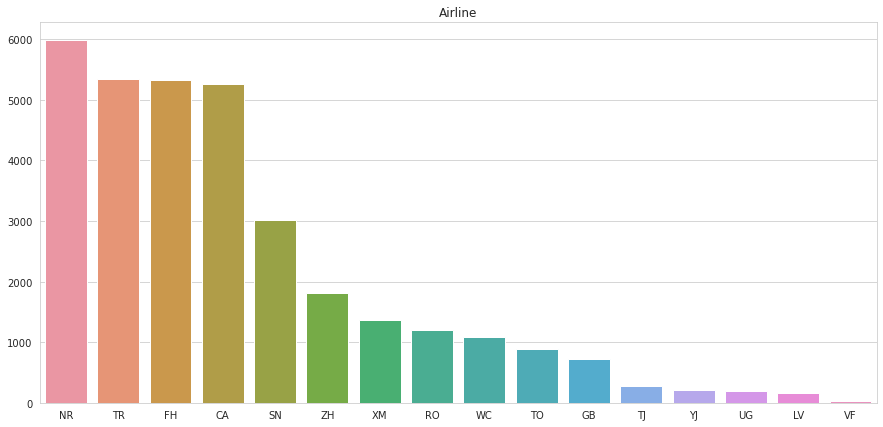

In [25]:
# plot the distribution of Airline
plot_general_bar(
    df_flight_hix, 
    'Airline', 
    'Plane_ID', 
    title='Airline', 
    outfile='Airline_bar.png',
    to_sort=True,
    ascending=False,
    n_limit=len(df_flight_hix['Airline'].unique())
)

/home/yao/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
2022-10-29 13:45:51 - numexpr.utils - INFO - 20489 - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-10-29 13:45:51 - numexpr.utils - INFO - 20489 - NumExpr defaulting to 8 threads.


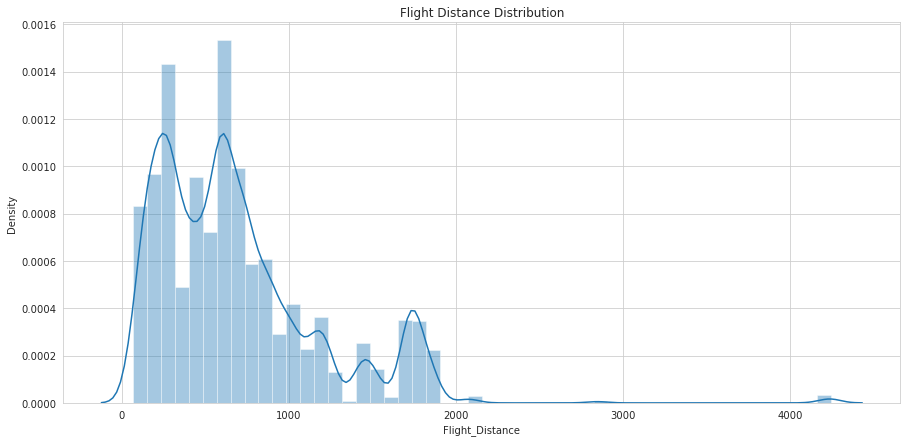

In [26]:
# plot the distribution of Flight Distance
plot_general_dist(df_flight_hix, 'Flight_Distance', 'Flight Distance Distribution', 'Flight_Distance_dist.png')

/home/yao/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


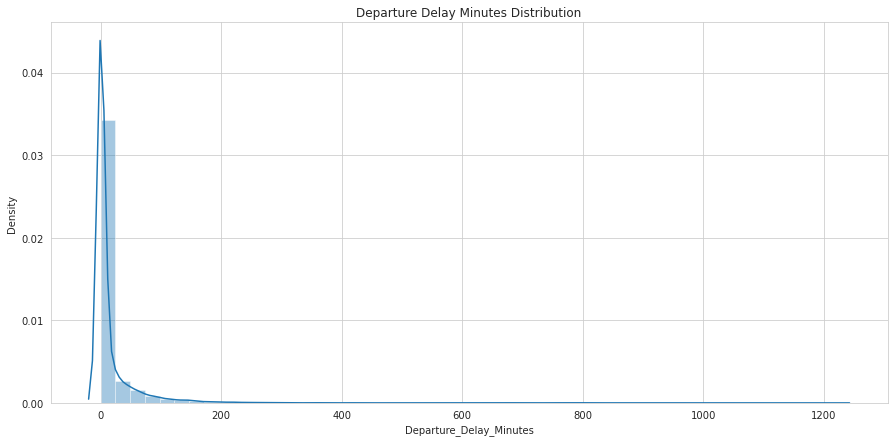

In [27]:
# plot the distribution of Departure Delay Minutes
plot_general_dist(
    df_flight_hix, 
    'Departure_Delay_Minutes', 
    'Departure Delay Minutes Distribution', 
    'Departure_Delay_Minutes_dist.png'
)

/home/yao/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


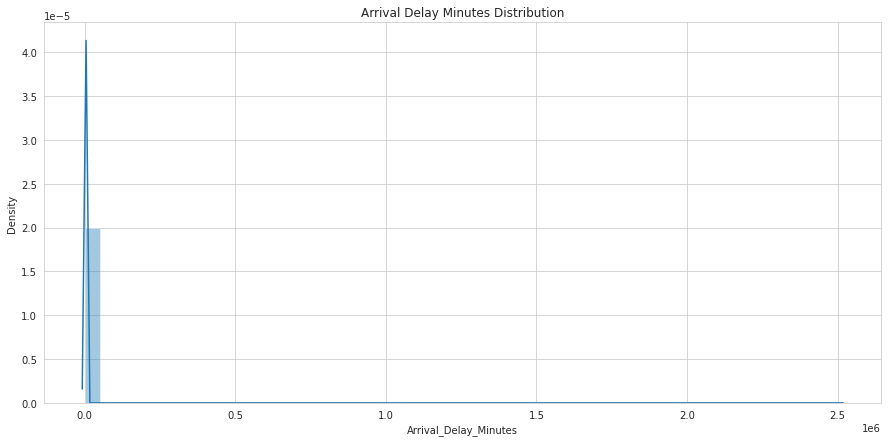

In [28]:
# plot the distribution of Arrival Delay Minutes
plot_general_dist(
    df_flight_hix, 
    'Arrival_Delay_Minutes', 
    'Arrival Delay Minutes Distribution', 
    'Arrival_Delay_Minutes_dist.png'
)

In [29]:
df_flight_hix[
    ['Flight_Distance', 'Departure_Delay_Minutes', 'Arrival_Delay_Minutes']
].describe([.1,.2,.3,.6,.7,.8,.9,.95,.98,.99,.999])

Flight_Distance  Departure_Delay_Minutes  Arrival_Delay_Minutes
count     32863.000000             32863.000000           3.286300e+04
mean        692.771902                15.907982           3.425158e+02
std         502.315076                53.117533           2.215887e+04
min          67.000000                 0.000000           0.000000e+00
10%         177.000000                 0.000000           0.000000e+00
20%         264.000000                 0.000000           0.000000e+00
30%         343.000000                 0.000000           0.000000e+00
50%         599.000000                 0.000000           0.000000e+00
60%         693.000000                 0.000000           0.000000e+00
70%         801.000000                 3.000000           6.000000e+00
80%        1007.000000                16.000000           1.900000e+01
90%        1440.000000                47.000000           4.800000e+01
95%        1739.000000                85.000000           8.500000e+01
98%        1846.000000               144.000000           1.470000e+02
99%        1846.000000               196.000000           2.023800e+02
99.9%      4243.000000               777.828000           8.353120e+02
max        4243.000000              1223.000000           2.510000e+06

In [30]:
# potential outliers
df_flight_hix[df_flight_hix['Arrival_Delay_Minutes']>10000]

Airline  Flight_Number Plane_ID  FlightDate Origin_Airport  \
2336       TR           3561   GDGSCV  2019-12-01            HIX   
16972      FH           4767   GCIPAB  2019-12-08            HIX   
33330      WC           2794   GJERQB  2019-12-16            HIX   
42345      TR           1933   GJDSNB  2019-12-20            HIX   
46745      ZH           5908   GBKRTX  2019-12-22            HIX   
47857      ZH           5816   GFGTTX  2019-12-22            HIX   
49542      GB           2481   GGFUAY  2019-12-23            HIX   
50990      RO           7374   GILPEK  2019-12-24            HIX   
58974      NR           3534   GFKVBZ  2019-12-28            HIX   
62456      FH           4919   GCLVAB  2019-12-30            HIX   
63805      CA           6355   GJGPRJ  2019-12-30            HIX   
64179      CA           4820   GCHQFM  2019-12-31            HIX   

      Destination_Airport  Flight_Distance  Scheduled_Departure_Time  \
2336                  IUR           1739.0                      2200   
16972                 ZIL            137.0                      1455   
33330                 TKF            606.0                       710   
42345                 ISC           1143.0                       835   
46745                 FKD           1081.0                      1009   
47857                 FUN            594.0                      1845   
49542                 IYR           1440.0                      1508   
50990                 CWE            740.0                      1040   
58974                 WVH            888.0                      1424   
62456                 AUH           1009.0                       950   
63805                 FBA            119.0                      2105   
64179                 LCW           1250.0                       721   

       Actual_Departure_Time  Departure_Delay_Minutes  Departure_Taxi  \
2336                  2229.0                     29.0            22.0   
16972                 1535.0                     40.0            24.0   
33330                  705.0                      0.0            58.0   
42345                 1014.0                     99.0            18.0   
46745                 1455.0                    286.0            11.0   
47857                 2004.0                     79.0            18.0   
49542                 1730.0                    142.0            13.0   
50990                 1147.0                     67.0            19.0   
58974                 1457.0                     33.0            18.0   
62456                 1039.0                     49.0            59.0   
63805                 2133.0                     28.0            38.0   
64179                 1221.0                    300.0            14.0   

       Departure_WheelsOff  Scheduled_Arrival_Time  Actual_Arrival_Time  \
2336                2251.0                      31                102.0   
16972               1559.0                    1654               1736.0   
33330                803.0                    1011               1043.0   
42345               1032.0                    1237               1407.0   
46745               1506.0                    1234               1631.0   
47857               2022.0                    2143               2240.0   
49542               1743.0                    1809               2018.0   
50990               1206.0                    1403               1450.0   
58974               1515.0                    1606               1650.0   
62456               1138.0                    1206               1311.0   
63805               2211.0                    2303               2349.0   
64179               1235.0                    1018               1429.0   

       Arrival_Delay_Minutes  Arrival_Taxi  Arrival_WheelsOn  Delay_Reason  
2336                310000.0           5.0              57.0  LateAircraft  
16972               420000.0           7.0            1729.0       Carrier  
33330               320000.

## 2. Preprocessing

### 1. Convert hour level weather data into daily level weather data to allow it to be joined with the flight data

In [31]:
# As the original weather data is on a hourly level, 
# we need to convert it into daily level first, 
# and then we will be able to use weather data as features and combine it with flight data

In [32]:
df_weather["FlightDate"] = df_weather.apply(
    lambda x: x['time'][:10], axis=1
)

In [33]:
df_weather

Unnamed: 0   airport                 time           summary  \
0             1  Highland  2019-11-30 00:00:00          Overcast   
1             2  Highland  2019-11-30 01:00:00  Possible Drizzle   
2             3  Highland  2019-11-30 02:00:00  Possible Drizzle   
3             4  Highland  2019-11-30 03:00:00        Light Rain   
4             5  Highland  2019-11-30 04:00:00          Overcast   
..          ...       ...                  ...               ...   
763         764  Highland  2019-12-31 19:00:00          Overcast   
764         765  Highland  2019-12-31 20:00:00     Mostly Cloudy   
765         766  Highland  2019-12-31 21:00:00     Partly Cloudy   
766         767  Highland  2019-12-31 22:00:00     Partly Cloudy   
767         768  Highland  2019-12-31 23:00:00             Clear   

     precipIntensity  precipProbability  temperature  apparentTemperature  \
0             0.0000               0.00        37.30                32.11   
1             0.0018               0.35        37.74                33.16   
2             0.0062               0.54        37.60                31.13   
3             0.0135               0.71        36.60                29.78   
4             0.0007               0.06        36.65                31.12   
..               ...                ...          ...                  ...   
763           0.0000               0.00        29.03                18.65   
764           0.0000               0.00        29.09                19.16   
765           0.0000               0.00        27.47                19.06   
766           0.0000               0.00        27.05                18.42   
767           0.0000               0.00        26.44                17.67   

     dewPoint  humidity  ...  windSpeed  windGust  windBearing  cloudCover  \
0       32.47      0.82  ...       6.70      8.06   141.090120        1.00   
1       32.10      0.80  ...       5.77      7.58   110.003815        0.95   
2       32.41      0.83  ...       8.04      8.57   112.053620        1.00   
3       31.76      0.83  ...       8.90      9.84   103.033220        1.00   
4       32.41      0.85  ...       6.95      8.95   104.085209        1.00   
..        ...       ...  ...        ...       ...          ...         ...   
763     20.19      0.69  ...      12.24     13.20   226.065707        0.93   
764     20.32      0.69  ...      12.27     13.07   279.065446        0.70   
765     20.17      0.73  ...       8.58     11.74   265.041445        0.49   
766     19.83      0.74  ...       8.23     11.02   270.015577        0.39   
767     19.00      0.73  ...       8.60     10.22   241.067190        0.26   

     uvIndex  visibility   ozone  precipType precipAccumulation  FlightDate  
0          0        10.0  309.69         NaN                NaN  2019-11-30  
1          0        10.0  309.09        rain                NaN  2019-11-30  
2          0        10.0  308.70        rain                NaN  2019-11-30  
3          0        10.0  309.40        rain                NaN  2019-11-30  
4          0        10.0  311.82        rain                NaN  2019-11-30  
..       ...         ...     ...         ...                ...         ...  
763        0        10.0  355.84         NaN                NaN  2019-12-31  
764        0        10.0  358.18         NaN                NaN  2019-12-31  
765        0        10.0  360.42         NaN                NaN  2019-12-31  
766        0        10.0  362.23         NaN                NaN  2019-12-31  
767        0        10.0  363.68         NaN                NaN  2019-12-31  

[768 rows x 21 columns]

In [34]:
df_weather.columns

Index(['Unnamed: 0', 'airport', 'time', 'summary', 'precipIntensity',
       'precipProbability', 'temperature', 'apparentTemperature', 'dewPoint',
       'humidity', 'pressure', 'windSpeed', 'windGust', 'windBearing',
       'cloudCover', 'uvIndex', 'visibility', 'ozone', 'precipType',
       'precipAccumulation', 'FlightDate'],
      dtype='object')

In [35]:
df_weather = df_weather.groupby(['FlightDate']).agg(
    summary=('summary', pd.Series.mode),
    precipIntensity=('precipIntensity', 'mean'),
    precipProbability=('precipProbability', 'mean'),
    temperature=('temperature', 'mean'),
    apparentTemperature=('apparentTemperature', 'mean'),
    dewPoint=('dewPoint', 'mean'),
    humidity=('humidity', 'mean'),
    pressure=('pressure', 'mean'),
    windSpeed=('windSpeed', 'mean'),
    windGust=('windGust', 'mean'),
    windBearing=('windBearing', 'mean'),
    cloudCover=('cloudCover', 'mean'),
    uvIndex=('uvIndex', 'mean'),
    visibility=('visibility', 'mean'),
    ozone=('ozone', 'mean'),
    precipType=('precipType', pd.Series.mode),
    precipAccumulation=('precipAccumulation', 'mean'),
).reset_index()


In [36]:
df_weather

FlightDate        summary  precipIntensity  precipProbability  \
0   2019-11-30       Overcast         0.013017           0.413333   
1   2019-12-01       Overcast         0.004792           0.281667   
2   2019-12-02       Overcast         0.000379           0.013750   
3   2019-12-03       Overcast         0.000258           0.006250   
4   2019-12-04          Clear         0.000000           0.000000   
5   2019-12-05          Clear         0.000000           0.000000   
6   2019-12-06          Clear         0.000000           0.000000   
7   2019-12-07          Clear         0.000000           0.000000   
8   2019-12-08       Overcast         0.000012           0.001250   
9   2019-12-09       Overcast         0.001063           0.115417   
10  2019-12-10          Clear         0.000075           0.000417   
11  2019-12-11          Clear         0.000000           0.000000   
12  2019-12-12  Mostly Cloudy         0.000000           0.000000   
13  2019-12-13  Mostly Cloudy         0.000000           0.000000   
14  2019-12-14       Overcast         0.000071           0.001667   
15  2019-12-15  Mostly Cloudy         0.000000           0.000000   
16  2019-12-16       Overcast         0.000042           0.015417   
17  2019-12-17          Clear         0.000000           0.000000   
18  2019-12-18  Partly Cloudy         0.000042           0.000417   
19  2019-12-19          Clear         0.000000           0.000000   
20  2019-12-20  Partly Cloudy         0.000000           0.000000   
21  2019-12-21          Clear         0.000000           0.000000   
22  2019-12-22          Clear         0.000000           0.000000   
23  2019-12-23          Clear         0.000000           0.000000   
24  2019-12-24  Mostly Cloudy         0.000000           0.000000   
25  2019-12-25  Mostly Cloudy         0.000000           0.000000   
26  2019-12-26  Mostly Cloudy         0.000042           0.000833   
27  2019-12-27       Overcast         0.000000           0.000000   
28  2019-12-28       Overcast         0.003017           0.062083   
29  2019-12-29       Overcast         0.034188           0.415417   
30  2019-12-30       Overcast         0.003700           0.209167   
31  2019-12-31       Overcast         0.000733           0.065000   

    temperature  apparentTemperature   dewPoint  humidity     pressure  \
0     37.582083            30.037083  33.678333  0.862083  1009.214167   
1     37.646250            31.508750  34.737083  0.897917   997.687083   
2     31.275417            23.839583  24.252083  0.752500  1015.747500   
3     33.948750            26.342083  26.682083  0.749583  1007.979167   
4     36.330833            28.950000  27.161250  0.698333  1006.584167   
5     36.769583            33.213750  27.945000  0.712083  1015.569167   
6     35.107083            29.884167  25.510833  0.684167  1023.711250   
7     32.011250            25.641250  22.447083  0.682500  1026.726250   
8     40.680417            35.127917  33.496667  0.762083  1013.089167   
9     41.700000            35.770000  37.557500  0.856667  1002.361667   
10    19.660000             7.942500   5.245000  0.538750  1021.377083   
11    18.801667            10.560417   4.935000  0.547917  1030.992083   
12    32.977083            25.078333  20.566250  0.607083  1024.147500   
13    38.151250            35.160833  27.574583  0.660833  1013.291250   
14    30.268750            23.809167  23.248750  0.755833  1008.306250   
15    23.672500            18.159167  12.036667  0.609167  1019.049583   
16    27.323333            21.562083  20.200000  0.747500  1022.059583   
17    24.946250            16.058750  16.970000  0.717083  1020.195833   
18    18.082500             9.046250  -4.015417  0.393333  1026.138333   
19    25.340833            17.851667  10.961667  0.553333  1025.840417   
20    30.882500            27.176667  22.881667  0.724583  1029.955000   
21    37.213750            31.830417  27.705833  0.688333  1027.010417   
22    39.918333         

### 2. Handling of features with high percentage of missing values or with outliers

#### 1.Delay_Reason

In [37]:
logger.info(f"Delay_Reason possible values: {df_flight_hix['Delay_Reason'].unique()}")

2022-10-29 13:45:53 - __main__ - INFO - 20489 - Delay_Reason possible values: [nan 'Weather' 'Carrier' 'LateAircraft' 'NAS' 'Security']


In [38]:
# fill empty values with (na)
df_flight_hix.loc[:, 'Delay_Reason'] = df_flight_hix['Delay_Reason'].fillna("(na)")

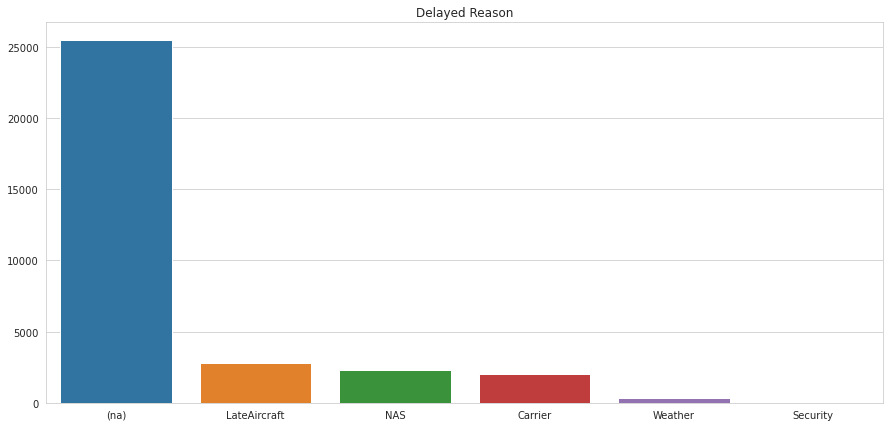

In [39]:
# plot the distribution of Delay_Reason
plot_general_bar(
    df_flight_hix, 
    'Delay_Reason', 
    'Airline', 
    title='Delayed Reason', 
    outfile='Delay_Reason_bar.png',
    to_sort=True,
    ascending=False
)

#### 2.precipType

In [40]:
# fill empty values with (na)
df_weather.loc[:, 'precipType'] = df_weather['precipType'].fillna("(na)")

In [41]:
l_precipType = df_weather['precipType']
for i in range(len(l_precipType)):
    if type(l_precipType[i]) is np.ndarray:
        l_precipType[i] = '(na)'
df_weather['precipType'] = l_precipType

<ipython-input-41-7528006f5fed>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l_precipType[i] = '(na)'


In [42]:
df_weather

FlightDate        summary  precipIntensity  precipProbability  \
0   2019-11-30       Overcast         0.013017           0.413333   
1   2019-12-01       Overcast         0.004792           0.281667   
2   2019-12-02       Overcast         0.000379           0.013750   
3   2019-12-03       Overcast         0.000258           0.006250   
4   2019-12-04          Clear         0.000000           0.000000   
5   2019-12-05          Clear         0.000000           0.000000   
6   2019-12-06          Clear         0.000000           0.000000   
7   2019-12-07          Clear         0.000000           0.000000   
8   2019-12-08       Overcast         0.000012           0.001250   
9   2019-12-09       Overcast         0.001063           0.115417   
10  2019-12-10          Clear         0.000075           0.000417   
11  2019-12-11          Clear         0.000000           0.000000   
12  2019-12-12  Mostly Cloudy         0.000000           0.000000   
13  2019-12-13  Mostly Cloudy         0.000000           0.000000   
14  2019-12-14       Overcast         0.000071           0.001667   
15  2019-12-15  Mostly Cloudy         0.000000           0.000000   
16  2019-12-16       Overcast         0.000042           0.015417   
17  2019-12-17          Clear         0.000000           0.000000   
18  2019-12-18  Partly Cloudy         0.000042           0.000417   
19  2019-12-19          Clear         0.000000           0.000000   
20  2019-12-20  Partly Cloudy         0.000000           0.000000   
21  2019-12-21          Clear         0.000000           0.000000   
22  2019-12-22          Clear         0.000000           0.000000   
23  2019-12-23          Clear         0.000000           0.000000   
24  2019-12-24  Mostly Cloudy         0.000000           0.000000   
25  2019-12-25  Mostly Cloudy         0.000000           0.000000   
26  2019-12-26  Mostly Cloudy         0.000042           0.000833   
27  2019-12-27       Overcast         0.000000           0.000000   
28  2019-12-28       Overcast         0.003017           0.062083   
29  2019-12-29       Overcast         0.034188           0.415417   
30  2019-12-30       Overcast         0.003700           0.209167   
31  2019-12-31       Overcast         0.000733           0.065000   

    temperature  apparentTemperature   dewPoint  humidity     pressure  \
0     37.582083            30.037083  33.678333  0.862083  1009.214167   
1     37.646250            31.508750  34.737083  0.897917   997.687083   
2     31.275417            23.839583  24.252083  0.752500  1015.747500   
3     33.948750            26.342083  26.682083  0.749583  1007.979167   
4     36.330833            28.950000  27.161250  0.698333  1006.584167   
5     36.769583            33.213750  27.945000  0.712083  1015.569167   
6     35.107083            29.884167  25.510833  0.684167  1023.711250   
7     32.011250            25.641250  22.447083  0.682500  1026.726250   
8     40.680417            35.127917  33.496667  0.762083  1013.089167   
9     41.700000            35.770000  37.557500  0.856667  1002.361667   
10    19.660000             7.942500   5.245000  0.538750  1021.377083   
11    18.801667            10.560417   4.935000  0.547917  1030.992083   
12    32.977083            25.078333  20.566250  0.607083  1024.147500   
13    38.151250            35.160833  27.574583  0.660833  1013.291250   
14    30.268750            23.809167  23.248750  0.755833  1008.306250   
15    23.672500            18.159167  12.036667  0.609167  1019.049583   
16    27.323333            21.562083  20.200000  0.747500  1022.059583   
17    24.946250            16.058750  16.970000  0.717083  1020.195833   
18    18.082500             9.046250  -4.015417  0.393333  1026.138333   
19    25.340833            17.851667  10.961667  0.553333  1025.840417   
20    30.882500            27.176667  22.881667  0.724583  1029.955000   
21    37.213750            31.830417  27.705833  0.688333  1027.010417   
22    39.918333         

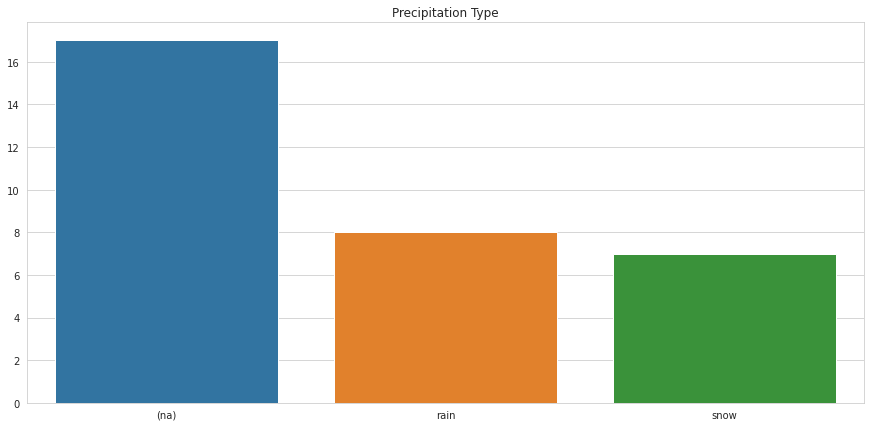

In [43]:
# plot the distribution of precipType
plot_general_bar(
    df_weather, 
    'precipType', 
    'summary', 
    title='Precipitation Type', 
    outfile='precipType_bar.png',
    to_sort=True,
    ascending=False
)

#### 3.precipAccumulation

/home/yao/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


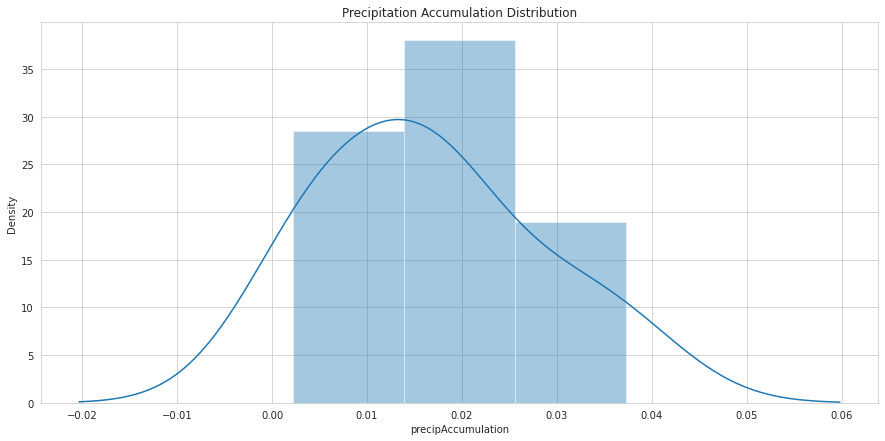

In [44]:
# plot the distribution of Precipitation Accumulation
plot_general_dist(
    df_weather, 
    'precipAccumulation', 
    'Precipitation Accumulation Distribution', 
    'precipAccumulation_Minutes_dist.png'
)

In [45]:
df_weather[
    ['precipAccumulation']
].describe([.1,.2,.3,.6,.7,.8,.9,.95,.98,.99,.999])

precipAccumulation
count            9.000000
mean             0.016571
std              0.011663
min              0.002200
10%              0.003800
20%              0.006060
30%              0.009970
50%              0.015800
60%              0.016840
70%              0.019488
80%              0.024728
90%              0.031617
95%              0.034450
98%              0.036150
99%              0.036717
99.9%            0.037227
max              0.037283

In [46]:
df_weather.loc[:, 'precipAccumulation'] = df_weather['precipAccumulation'].fillna(
    0.0
)

/home/yao/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


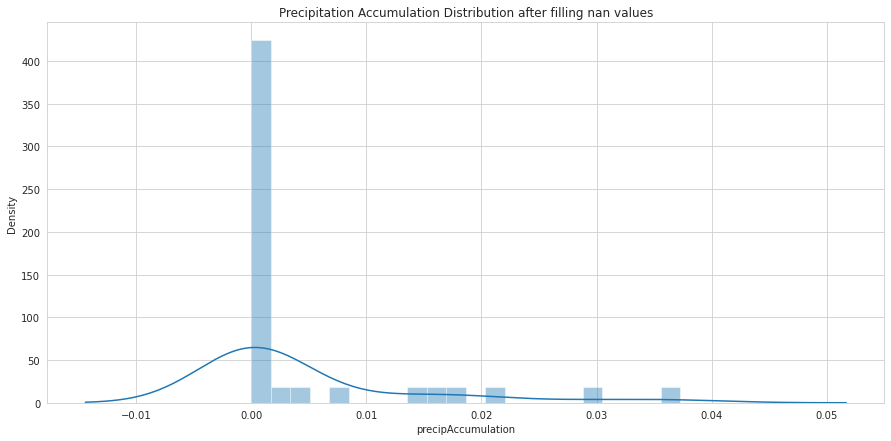

In [47]:
# plot the distribution of Precipitation Accumulation
plot_general_dist(
    df_weather, 
    'precipAccumulation', 
    'Precipitation Accumulation Distribution after filling nan values', 
    'precipAccumulation_Minutes_dist(w_o_nan).png'
)

In [48]:
df_weather[
    ['precipAccumulation']
].describe([.1,.2,.3,.6,.7,.8,.9,.95,.98,.99,.999])

precipAccumulation
count           32.000000
mean             0.004661
std              0.009613
min              0.000000
10%              0.000000
20%              0.000000
30%              0.000000
50%              0.000000
60%              0.000000
70%              0.000000
80%              0.006680
90%              0.016970
95%              0.025184
98%              0.032892
99%              0.035088
99.9%            0.037064
max              0.037283

In [49]:
df_weather

FlightDate        summary  precipIntensity  precipProbability  \
0   2019-11-30       Overcast         0.013017           0.413333   
1   2019-12-01       Overcast         0.004792           0.281667   
2   2019-12-02       Overcast         0.000379           0.013750   
3   2019-12-03       Overcast         0.000258           0.006250   
4   2019-12-04          Clear         0.000000           0.000000   
5   2019-12-05          Clear         0.000000           0.000000   
6   2019-12-06          Clear         0.000000           0.000000   
7   2019-12-07          Clear         0.000000           0.000000   
8   2019-12-08       Overcast         0.000012           0.001250   
9   2019-12-09       Overcast         0.001063           0.115417   
10  2019-12-10          Clear         0.000075           0.000417   
11  2019-12-11          Clear         0.000000           0.000000   
12  2019-12-12  Mostly Cloudy         0.000000           0.000000   
13  2019-12-13  Mostly Cloudy         0.000000           0.000000   
14  2019-12-14       Overcast         0.000071           0.001667   
15  2019-12-15  Mostly Cloudy         0.000000           0.000000   
16  2019-12-16       Overcast         0.000042           0.015417   
17  2019-12-17          Clear         0.000000           0.000000   
18  2019-12-18  Partly Cloudy         0.000042           0.000417   
19  2019-12-19          Clear         0.000000           0.000000   
20  2019-12-20  Partly Cloudy         0.000000           0.000000   
21  2019-12-21          Clear         0.000000           0.000000   
22  2019-12-22          Clear         0.000000           0.000000   
23  2019-12-23          Clear         0.000000           0.000000   
24  2019-12-24  Mostly Cloudy         0.000000           0.000000   
25  2019-12-25  Mostly Cloudy         0.000000           0.000000   
26  2019-12-26  Mostly Cloudy         0.000042           0.000833   
27  2019-12-27       Overcast         0.000000           0.000000   
28  2019-12-28       Overcast         0.003017           0.062083   
29  2019-12-29       Overcast         0.034188           0.415417   
30  2019-12-30       Overcast         0.003700           0.209167   
31  2019-12-31       Overcast         0.000733           0.065000   

    temperature  apparentTemperature   dewPoint  humidity     pressure  \
0     37.582083            30.037083  33.678333  0.862083  1009.214167   
1     37.646250            31.508750  34.737083  0.897917   997.687083   
2     31.275417            23.839583  24.252083  0.752500  1015.747500   
3     33.948750            26.342083  26.682083  0.749583  1007.979167   
4     36.330833            28.950000  27.161250  0.698333  1006.584167   
5     36.769583            33.213750  27.945000  0.712083  1015.569167   
6     35.107083            29.884167  25.510833  0.684167  1023.711250   
7     32.011250            25.641250  22.447083  0.682500  1026.726250   
8     40.680417            35.127917  33.496667  0.762083  1013.089167   
9     41.700000            35.770000  37.557500  0.856667  1002.361667   
10    19.660000             7.942500   5.245000  0.538750  1021.377083   
11    18.801667            10.560417   4.935000  0.547917  1030.992083   
12    32.977083            25.078333  20.566250  0.607083  1024.147500   
13    38.151250            35.160833  27.574583  0.660833  1013.291250   
14    30.268750            23.809167  23.248750  0.755833  1008.306250   
15    23.672500            18.159167  12.036667  0.609167  1019.049583   
16    27.323333            21.562083  20.200000  0.747500  1022.059583   
17    24.946250            16.058750  16.970000  0.717083  1020.195833   
18    18.082500             9.046250  -4.015417  0.393333  1026.138333   
19    25.340833            17.851667  10.961667  0.553333  1025.840417   
20    30.882500            27.176667  22.881667  0.724583  1029.955000   
21    37.213750            31.830417  27.705833  0.688333  1027.010417   
22    39.918333         

In [50]:
df_flight_hix.shape

(32863, 18)

### 3. Join weather data with flight data

In [51]:
df_flight_combined_data = pd.merge(
    df_flight_hix,
    df_weather,
    how='left',
    on=['FlightDate']
)

In [52]:
df_flight_combined_data.head()

Airline  Flight_Number Plane_ID  FlightDate Origin_Airport  \
0      RO           4754   GHHWLL  2019-12-01            HIX   
1      XM           5604   GBGWFC  2019-12-01            HIX   
2      XM           5612   GBISBC  2019-12-01            HIX   
3      XM           5615   GBJODX  2019-12-01            HIX   
4      XM           5661   GBESAF  2019-12-01            HIX   

  Destination_Airport  Flight_Distance  Scheduled_Departure_Time  \
0                 IZN            413.0                        10   
1                 IZU            130.0                        10   
2                 LKF            258.0                        10   
3                 MPM            475.0                        10   
4                 EZN            552.0                        10   

   Actual_Departure_Time  Departure_Delay_Minutes  ...    pressure  windSpeed  \
0                   10.0                      0.0  ...  997.687083    8.58625   
1                   44.0                     34.0  ...  997.687083    8.58625   
2                  234.0                    144.0  ...  997.687083    8.58625   
3                  144.0                     94.0  ...  997.687083    8.58625   
4                   14.0                      4.0  ...  997.687083    8.58625   

   windGust  windBearing  cloudCover   uvIndex  visibility       ozone  \
0   10.0025    246.35004     0.97875  0.166667    7.119417  409.575417   
1   10.0025    246.35004     0.97875  0.166667    7.119417  409.575417   
2   10.0025    246.35004     0.97875  0.166667    7.119417  409.575417   
3   10.0025    246.35004     0.97875  0.166667    7.119417  409.575417   
4   10.0025    246.35004     0.97875  0.166667    7.119417  409.575417   

  precipType  precipAccumulation  
0       rain             0.02108  
1       rain             0.02108  
2       rain             0.02108  
3       rain             0.02108  
4       rain             0.02108  

[5 rows x 35 columns]

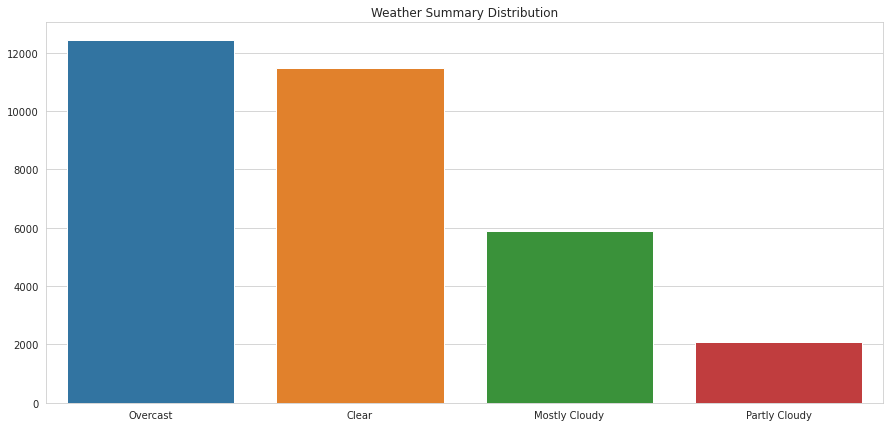

In [53]:
# plot the distribution of summary
plot_general_bar(
    df_flight_combined_data, 
    'summary', 
    'Airline', 
    title='Weather Summary Distribution', 
    outfile='summary_bar.png',
    to_sort=True,
    ascending=False
)

## 3. Model building

In [54]:
df_flight_combined_data.shape

(32863, 35)

### 1. Generate target feature: is_delayed and some additional training features from FlightDate

In [55]:
df_flight_combined_data['is_delayed'] = df_flight_combined_data['Arrival_Delay_Minutes'] >= 15

In [56]:
df_flight_combined_data['FlightDate'] = pd.to_datetime(df_flight_combined_data['FlightDate'])

In [57]:
df_flight_combined_data['day_of_week'] = df_flight_combined_data['FlightDate'].dt.day_name()

In [58]:
df_flight_combined_data['week_of_year'] = df_flight_combined_data['FlightDate'].dt.isocalendar().week

In [59]:
df_flight_combined_data

Airline  Flight_Number Plane_ID FlightDate Origin_Airport  \
0          RO           4754   GHHWLL 2019-12-01            HIX   
1          XM           5604   GBGWFC 2019-12-01            HIX   
2          XM           5612   GBISBC 2019-12-01            HIX   
3          XM           5615   GBJODX 2019-12-01            HIX   
4          XM           5661   GBESAF 2019-12-01            HIX   
...       ...            ...      ...        ...            ...   
32858      UG           1426   GCGOWP 2019-12-31            HIX   
32859      GB           2217   GGMRAY 2019-12-31            HIX   
32860      FH           5141   GCFPAG 2019-12-31            HIX   
32861      TR           4100   GBFTNB 2019-12-31            HIX   
32862      NR           3210   GGMVZF 2019-12-31            HIX   

      Destination_Airport  Flight_Distance  Scheduled_Departure_Time  \
0                     IZN            413.0                        10   
1                     IZU            130.0                        10   
2                     LKF            258.0                        10   
3                     MPM            475.0                        10   
4                     EZN            552.0                        10   
...                   ...              ...                       ...   
32858                 UFM            867.0                      2138   
32859                 WWQ            801.0                      2145   
32860                 YRL            557.0                      2200   
32861                 ERR           1744.0                      2217   
32862                 LAO           2072.0                      2242   

       Actual_Departure_Time  Departure_Delay_Minutes  ...  windBearing  \
0                       10.0                      0.0  ...   246.350040   
1                       44.0                     34.0  ...   246.350040   
2                      234.0                    144.0  ...   246.350040   
3                      144.0                     94.0  ...   246.350040   
4                       14.0                      4.0  ...   246.350040   
...                      ...                      ...  ...          ...   
32858                 2128.0                      0.0  ...   262.499526   
32859                 2139.0                      0.0  ...   262.499526   
32860                 2222.0                     22.0  ...   262.499526   
32861                 2216.0                      0.0  ...   262.499526   
32862                 2232.0                      0.0  ...   262.499526   

       cloudCover   uvIndex  visibility       ozone  precipType  \
0        0.978750  0.166667    7.119417  409.575417        rain   
1        0.978750  0.166667    7.119417  409.575417        rain   
2        0.978750  0.166667    7.119417  409.575417        rain   
3        0.978750  0.166667    7.119417  409.575417        rain   
4        0.978750  0.166667    7.119417  409.575417        rain   
...           ...       ...         ...         ...         ...   
32858    0.887917  0.208333    8.009250  360.156250        snow   
32859    0.887917  0.208333    8.009250  360.156250        snow   
32860    0.887917  0.208333    8.009250  360.156250        snow   
32861    0.887917  0.208333    8.009250  360.156250        snow   
32862    0.887917  0.208333    8.009250  360.156250        snow   

       precipAccumulation is_delayed day_of_week  week_of_year  
0                0.021080      False      Sunday            48  
1                0.021080       True      Sunday            48  
2                0.021080       True      Sunday            48  
3                0.021080       True      Sunday            48  
4                0.021080      False      Sunday            48  
...                   ...        ...         ...           ...  
32858            0.037283      False     Tuesday             1  
32859            0.037283      False     Tuesday             1  
32860            0.037283      False     Tues

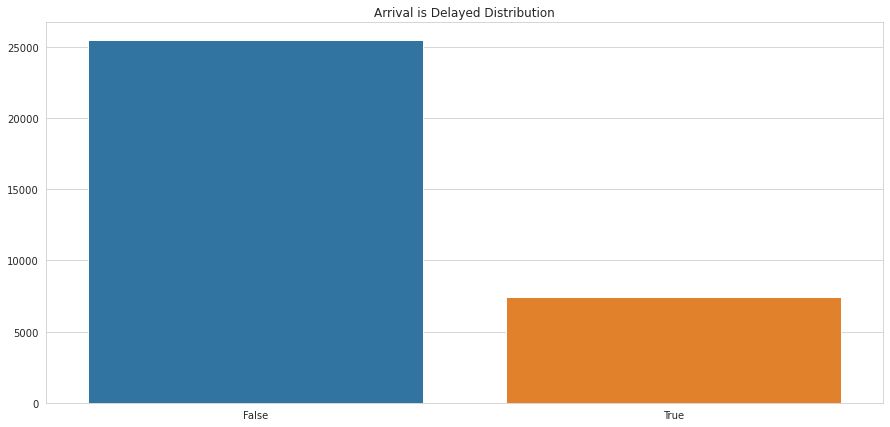

In [60]:
# plot the distribution of is_delayed
plot_general_bar(
    df_flight_combined_data, 
    'is_delayed', 
    'Airline', 
    title='Arrival is Delayed Distribution', 
    outfile='is_delayed_bar.png',
    to_sort=True,
    ascending=False
)

In [61]:
df_flight_combined_data

Airline  Flight_Number Plane_ID FlightDate Origin_Airport  \
0          RO           4754   GHHWLL 2019-12-01            HIX   
1          XM           5604   GBGWFC 2019-12-01            HIX   
2          XM           5612   GBISBC 2019-12-01            HIX   
3          XM           5615   GBJODX 2019-12-01            HIX   
4          XM           5661   GBESAF 2019-12-01            HIX   
...       ...            ...      ...        ...            ...   
32858      UG           1426   GCGOWP 2019-12-31            HIX   
32859      GB           2217   GGMRAY 2019-12-31            HIX   
32860      FH           5141   GCFPAG 2019-12-31            HIX   
32861      TR           4100   GBFTNB 2019-12-31            HIX   
32862      NR           3210   GGMVZF 2019-12-31            HIX   

      Destination_Airport  Flight_Distance  Scheduled_Departure_Time  \
0                     IZN            413.0                        10   
1                     IZU            130.0                        10   
2                     LKF            258.0                        10   
3                     MPM            475.0                        10   
4                     EZN            552.0                        10   
...                   ...              ...                       ...   
32858                 UFM            867.0                      2138   
32859                 WWQ            801.0                      2145   
32860                 YRL            557.0                      2200   
32861                 ERR           1744.0                      2217   
32862                 LAO           2072.0                      2242   

       Actual_Departure_Time  Departure_Delay_Minutes  ...  windBearing  \
0                       10.0                      0.0  ...   246.350040   
1                       44.0                     34.0  ...   246.350040   
2                      234.0                    144.0  ...   246.350040   
3                      144.0                     94.0  ...   246.350040   
4                       14.0                      4.0  ...   246.350040   
...                      ...                      ...  ...          ...   
32858                 2128.0                      0.0  ...   262.499526   
32859                 2139.0                      0.0  ...   262.499526   
32860                 2222.0                     22.0  ...   262.499526   
32861                 2216.0                      0.0  ...   262.499526   
32862                 2232.0                      0.0  ...   262.499526   

       cloudCover   uvIndex  visibility       ozone  precipType  \
0        0.978750  0.166667    7.119417  409.575417        rain   
1        0.978750  0.166667    7.119417  409.575417        rain   
2        0.978750  0.166667    7.119417  409.575417        rain   
3        0.978750  0.166667    7.119417  409.575417        rain   
4        0.978750  0.166667    7.119417  409.575417        rain   
...           ...       ...         ...         ...         ...   
32858    0.887917  0.208333    8.009250  360.156250        snow   
32859    0.887917  0.208333    8.009250  360.156250        snow   
32860    0.887917  0.208333    8.009250  360.156250        snow   
32861    0.887917  0.208333    8.009250  360.156250        snow   
32862    0.887917  0.208333    8.009250  360.156250        snow   

       precipAccumulation is_delayed day_of_week  week_of_year  
0                0.021080      False      Sunday            48  
1                0.021080       True      Sunday            48  
2                0.021080       True      Sunday            48  
3                0.021080       True      Sunday            48  
4                0.021080      False      Sunday            48  
...                   ...        ...         ...           ...  
32858            0.037283      False     Tuesday             1  
32859            0.037283      False     Tuesday             1  
32860            0.037283      False     Tues

In [62]:
df_flight_combined_data.columns

Index(['Airline', 'Flight_Number', 'Plane_ID', 'FlightDate', 'Origin_Airport',
       'Destination_Airport', 'Flight_Distance', 'Scheduled_Departure_Time',
       'Actual_Departure_Time', 'Departure_Delay_Minutes', 'Departure_Taxi',
       'Departure_WheelsOff', 'Scheduled_Arrival_Time', 'Actual_Arrival_Time',
       'Arrival_Delay_Minutes', 'Arrival_Taxi', 'Arrival_WheelsOn',
       'Delay_Reason', 'summary', 'precipIntensity', 'precipProbability',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'pressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover',
       'uvIndex', 'visibility', 'ozone', 'precipType', 'precipAccumulation',
       'is_delayed', 'day_of_week', 'week_of_year'],
      dtype='object')

### 2. Train catboost classification model

In [63]:
from ml_utils import (
    FeatureDefinition,
    get_train_test_indices,
    train_test_pools_from_dataframe,
    train_test_sets_from_dataframe,
    untransformed_data_from_dataframe,
)

In [64]:
from typing import Callable

CATEGORICAL = [
    'Airline', 'Plane_ID', 'Destination_Airport', 'summary', 'precipType', 'day_of_week'
]

CONTINUOUS_STANDARD_SCALED = [
    'Flight_Distance', 'Scheduled_Departure_Time', 'Scheduled_Arrival_Time',
    'precipIntensity', 'precipProbability',
    'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
    'pressure', 'windSpeed', 'windGust', 'windBearing',
    'cloudCover', 'uvIndex', 'visibility', 'ozone',
    'precipAccumulation'
]
CONTINUOUS_UNSCALED = ['Flight_Number', 'week_of_year']

continuous_cols = (
    CONTINUOUS_STANDARD_SCALED
    + CONTINUOUS_UNSCALED
)

# forcing all numerical columns to float as many ML models prefer float anyway
for col in continuous_cols:
    df_flight_combined_data[col] = df_flight_combined_data[col].astype(float)

for col in CATEGORICAL:
    df_flight_combined_data[col] = df_flight_combined_data[col].astype(str)

df_flight_combined_data.loc[:, continuous_cols] = df_flight_combined_data[continuous_cols].fillna(
    0.0
)  # make sure this is a float!
df_flight_combined_data.loc[:, CATEGORICAL] = df_flight_combined_data[CATEGORICAL].fillna("(na)")

def define_features(
    flight_data: pd.DataFrame,
    for_catboost: bool = False,
    categorical=CATEGORICAL,
    continuous_standard_scaled=CONTINUOUS_STANDARD_SCALED,
    continuous_unscaled=CONTINUOUS_UNSCALED,
) -> FeatureDefinition:
    feature_def = FeatureDefinition(for_catboost)
    feature_def.add_categorical_columns(categorical, flight_data)
    for col in continuous_standard_scaled:
        feature_def.add_continuous_column_standard_scaled(col, flight_data)
    for col in continuous_unscaled:
        feature_def.add_continuous_column(col, flight_data)

    return feature_def

def train_catboost_model(
    flight_data: pd.DataFrame,
    iterations=200,
    depth=7,
    od_wait=20,
    define_features_func: Callable[
        [pd.DataFrame, bool], FeatureDefinition
    ] = define_features,
    search_hyperopt=False,
):
    from catboost import CatBoostClassifier, cv

    flight_delay_features = define_features_func(flight_data, for_catboost=True)
    weight = None

    model_type = "classifier"  # "classifier", "regressor"

    logger.info("training model")
    if model_type == "classifier":

        logger.info(f"Pool dtypes: {flight_data.dtypes}")
        flight_data["is_delayed"] = flight_data["is_delayed"].astype(float)
        (
            train_pool,
            test_pool,
            feature_names,
            ind_train,
            ind_test,
        ) = train_test_pools_from_dataframe(
            flight_data,
            target_column="is_delayed",
            test_fraction=0.4,
            feature_def=flight_delay_features,
            return_train_test_indices=True,
            weight=weight,
        )

        if search_hyperopt:
            import warnings
            from bayes_opt import BayesianOptimization
            # search for optimal hyperparameters with bayesian optimization
            def catboostcv(n_estimators,
                           depth,
                           learning_rate,
                           max_bin,
                           subsample,
                           num_leaves,
                           l2_leaf_reg,
                           model_size_reg,
                           bagging_temperature):
                params = {
                    "n_estimators": int(n_estimators),
                    "depth": int(round(depth)),
                    "learning_rate": learning_rate,
                    "max_bin": int(max_bin),
                    "subsample": subsample,
                    "num_leaves": int(num_leaves),
                    "l2_leaf_reg": l2_leaf_reg,
                    "model_size_reg": model_size_reg,
                    "bagging_temperature": bagging_temperature,
                    "eval_metric": "Accuracy",
                    "loss_function": "Logloss",
                    "verbose": False,
                    "use_best_model": True,
                    "grow_policy": "Lossguide",
                    "od_type": "Iter",
                    "od_wait": od_wait,
                }
                scores = cv(train_pool,
                            params,
                            fold_count=5)
                return np.max(scores['test-F1-mean'])  # Return maximum Accuracy value

            catboostBO = BayesianOptimization(catboostcv,
                                             {"n_estimators": (150,400),
                                              "depth": (2,7),
                                              "learning_rate": (.01, 0.2),
                                              "subsample":(0.6, 1.),
                                              "num_leaves": (16,40),
                                              "max_bin":(150,300),
                                              "l2_leaf_reg":(0,10),
                                              "model_size_reg": (0,10),
                                              'bagging_temperature': (3,10)
                                              })

            with warnings.catch_warnings():
                # warnings.filterwarnings('ignore')
                catboostBO.maximize(init_points=2, n_iter=10)
            logger.info('-'*100)
            logger.info('Final Results')
            logger.info('Maximum Catboost value: %f' % catboostBO.max['target'])
            logger.info("Loging dict ---> {0}".format(catboostBO.max['params']))

            max_params = catboostBO.max['params']

            model = CatBoostClassifier(
                depth=int(round(max_params['depth'])),
                learning_rate=max_params['learning_rate'],
                n_estimators=int(max_params['n_estimators']),
                thread_count=-1,
                subsample=max_params['subsample'],
                num_leaves=int(max_params['num_leaves']),
                max_bin=int(max_params['max_bin']),
                l2_leaf_reg=max_params['l2_leaf_reg'],
                model_size_reg=max_params['model_size_reg'],
                verbose=True,
                grow_policy="Lossguide",
                loss_function="Logloss",
                od_type="Iter",
                od_wait=od_wait,
                eval_metric="F1",
                )
        else:
            model = CatBoostClassifier(
                iterations=iterations,
                loss_function="Logloss",
                verbose=True,
                depth=depth,
                od_wait=od_wait,
                eval_metric="F1",
                )

        # Fit model
        model.fit(train_pool, eval_set=test_pool, verbose=True)

        preds_class = model.predict(test_pool)
        preds_proba = model.predict_proba(test_pool)[
            :, 1
        ]  # column 1: True label (is_delayed)


    else:
        raise (Exception(f"Wrong model_type specified: {model_type}"))

    # Get predicted probabilities for each class
    # preds_proba = np.array(model.predict_proba(test_pool))
    actual = test_pool.get_label()
    err = (preds_class != actual).sum() / len(actual)

    from sklearn.metrics import (
        accuracy_score,
        f1_score,
        mean_squared_error,
        precision_score,
        r2_score,
        recall_score,
        roc_auc_score,
    )

    acc = accuracy_score(y_true=actual, y_pred=preds_class)
    prec = precision_score(y_true=actual, y_pred=preds_class)
    rec = recall_score(y_true=actual, y_pred=preds_class)
    auc = roc_auc_score(y_true=actual, y_score=preds_proba)
    f1 = f1_score(y_true=actual, y_pred=preds_class)

    logger.info(f"test error (n_false / N): {err}")
    logger.info(f"accuracy: {acc}")
    logger.info(f"precision: {prec}")
    logger.info(f"recall: {rec}")
    logger.info(f"auc: {auc}")
    logger.info(f"f1: {f1}")

    train_data = untransformed_data_from_dataframe(
        flight_data, flight_delay_features, ind_train
    )


    predicted_probabilites = np.array(
        [probas[1] for probas in model.predict_proba(train_pool)]
    )
    predicted_labels = model.predict(train_pool)
    true_labels = np.array(train_pool.get_label())



    return model, err, train_pool, test_pool, feature_names


In [65]:
model, err, train_pool, test_pool, feature_names = train_catboost_model(
    df_flight_combined_data
)

2022-10-29 13:45:54 - __main__ - INFO - 20489 - training model
2022-10-29 13:45:54 - __main__ - INFO - 20489 - Pool dtypes: Airline                             object
Flight_Number                      float64
Plane_ID                            object
FlightDate                  datetime64[ns]
Origin_Airport                      object
Destination_Airport                 object
Flight_Distance                    float64
Scheduled_Departure_Time           float64
Actual_Departure_Time              float64
Departure_Delay_Minutes            float64
Departure_Taxi                     float64
Departure_WheelsOff                float64
Scheduled_Arrival_Time             float64
Actual_Arrival_Time                float64
Arrival_Delay_Minutes              float64
Arrival_Taxi                       float64
Arrival_WheelsOn                   float64
Delay_Reason                        object
summary                             object
precipIntensity                    float64
precipProbabilit

Learning rate set to 0.133287
0:	learn: 0.1534455	test: 0.1621305	best: 0.1621305 (0)	total: 62.5ms	remaining: 12.4s
1:	learn: 0.2261260	test: 0.2448649	best: 0.2448649 (1)	total: 76.9ms	remaining: 7.61s
2:	learn: 0.2248831	test: 0.2448649	best: 0.2448649 (1)	total: 92.3ms	remaining: 6.06s
3:	learn: 0.2534579	test: 0.2659430	best: 0.2659430 (3)	total: 108ms	remaining: 5.27s
4:	learn: 0.2358994	test: 0.2409772	best: 0.2659430 (3)	total: 119ms	remaining: 4.65s
5:	learn: 0.2676525	test: 0.2775686	best: 0.2775686 (5)	total: 133ms	remaining: 4.29s
6:	learn: 0.2369272	test: 0.2500000	best: 0.2775686 (5)	total: 136ms	remaining: 3.75s
7:	learn: 0.2552395	test: 0.2661224	best: 0.2775686 (5)	total: 148ms	remaining: 3.56s
8:	learn: 0.2645857	test: 0.2831001	best: 0.2831001 (8)	total: 162ms	remaining: 3.44s
9:	learn: 0.2783373	test: 0.2976127	best: 0.2976127 (9)	total: 176ms	remaining: 3.35s
10:	learn: 0.2927887	test: 0.3125814	best: 0.3125814 (10)	total: 191ms	remaining: 3.28s
11:	learn: 0.296135

98:	learn: 0.4173280	test: 0.3928826	best: 0.3942194 (96)	total: 1.44s	remaining: 1.47s
99:	learn: 0.4199077	test: 0.3967803	best: 0.3967803 (99)	total: 1.46s	remaining: 1.46s
100:	learn: 0.4216590	test: 0.3946995	best: 0.3967803 (99)	total: 1.48s	remaining: 1.45s
101:	learn: 0.4215380	test: 0.3955577	best: 0.3967803 (99)	total: 1.49s	remaining: 1.43s
102:	learn: 0.4235643	test: 0.3965965	best: 0.3967803 (99)	total: 1.5s	remaining: 1.42s
103:	learn: 0.4227348	test: 0.3983011	best: 0.3983011 (103)	total: 1.52s	remaining: 1.4s
104:	learn: 0.4225445	test: 0.3984909	best: 0.3984909 (104)	total: 1.53s	remaining: 1.38s
105:	learn: 0.4228232	test: 0.3979231	best: 0.3984909 (104)	total: 1.54s	remaining: 1.37s
106:	learn: 0.4233432	test: 0.3970727	best: 0.3984909 (104)	total: 1.55s	remaining: 1.35s
107:	learn: 0.4245221	test: 0.3976443	best: 0.3984909 (104)	total: 1.57s	remaining: 1.33s
108:	learn: 0.4258192	test: 0.3959463	best: 0.3984909 (104)	total: 1.58s	remaining: 1.32s
109:	learn: 0.42369

2022-10-29 13:45:56 - __main__ - INFO - 20489 - test error (n_false / N): 0.19321466605811655
2022-10-29 13:45:56 - __main__ - INFO - 20489 - accuracy: 0.8067853339418835
2022-10-29 13:45:56 - __main__ - INFO - 20489 - precision: 0.6879489225857941
2022-10-29 13:45:56 - __main__ - INFO - 20489 - recall: 0.28628362670209234
2022-10-29 13:45:56 - __main__ - INFO - 20489 - auc: 0.750054372251588
2022-10-29 13:45:56 - __main__ - INFO - 20489 - f1: 0.40431519699812385


145:	learn: 0.4525785	test: 0.4035748	best: 0.4043152 (127)	total: 2.07s	remaining: 766ms
146:	learn: 0.4545307	test: 0.4032902	best: 0.4043152 (127)	total: 2.09s	remaining: 752ms
147:	learn: 0.4561118	test: 0.4016933	best: 0.4043152 (127)	total: 2.1s	remaining: 738ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.404315197
bestIteration = 127

Shrink model to first 128 iterations.


In [66]:


preds_class = model.predict(test_pool)
preds_proba = model.predict_proba(test_pool)[
    :, 1
] 

actual = test_pool.get_label()
err = (preds_class != actual).sum() / len(actual)



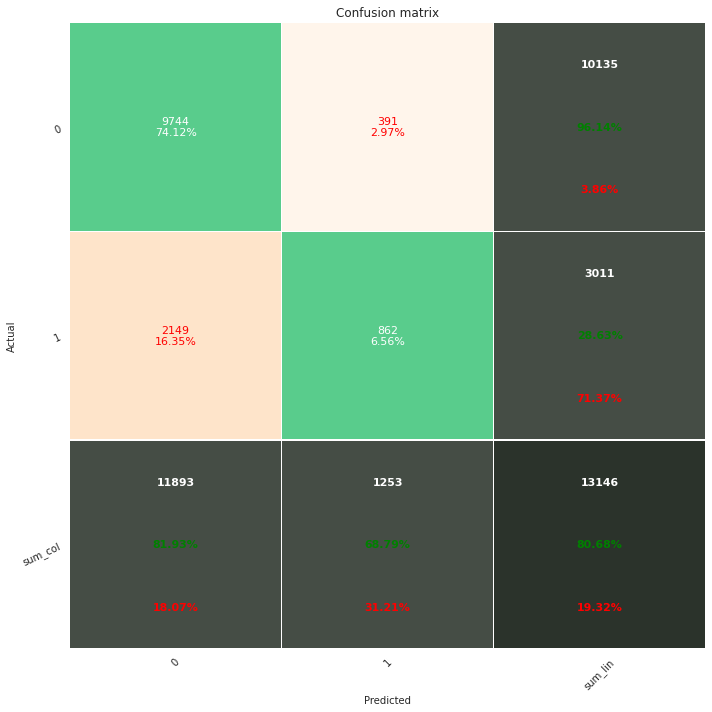

In [67]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')


conf_matrix = confusion_matrix(actual, preds_class)  
#conf_matrix = conf_matrix / conf_matrix.astype(float).sum(axis=1)

df_cm = pd.DataFrame(conf_matrix, range(2), range(2))
#plt.figure(figsize = (10,7))
#sns.set(font_scale=1.4)#for label size
#sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

#plt.savefig("confusion_matrix_f1.png")

pretty_plot_confusion_matrix(df_cm, pred_val_axis='x', figsize=[10,10], outfile='confusion_matrix_accuracy.png')



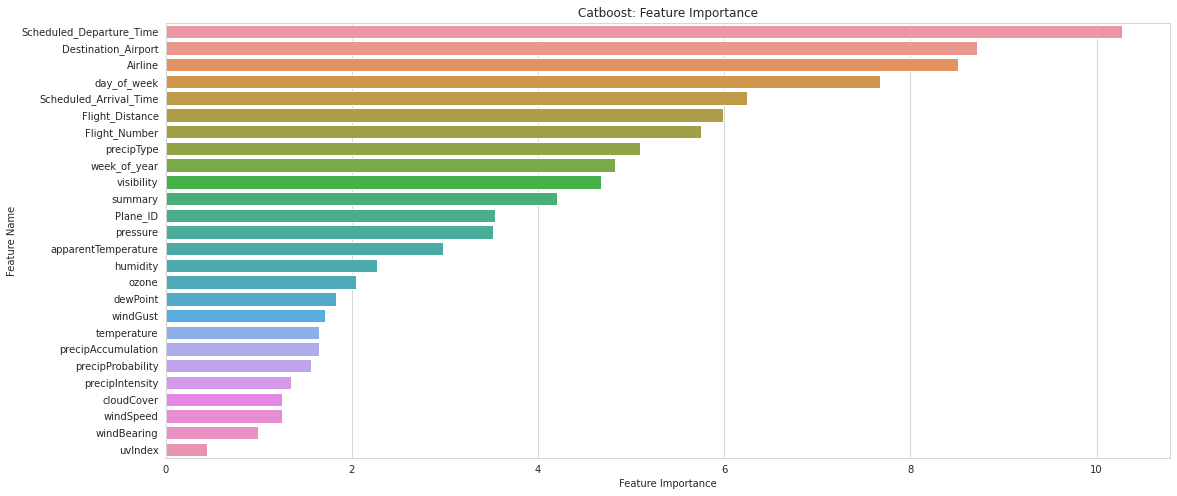

In [69]:
plot_feature_importance(model.get_feature_importance(),
                        feature_names,
                        'Catboost',
                        outfile='feature_importance_bar.png')


# Summary

## Challenges:
1. Data missing in Delayed_Reason, precipType and precipAccumulation (Actions taken: filled with (nan) or 0)
2. Flight data only contains daily level FlightDate data, while the weather data contains hours data. The prediction model would have better performance if we have exact hour / minute of the flight time.
3. Other insights can be seen via the visualisations. For example, Arrival delay is only a minority of all flights. This means the data is imbalanced. We will need to consult with domain experts to see what metrics we should optimize our model(s) with. Currently using F1 score, but it could be other metrics, or even custom built metrics based on domain knowledge (like custom cost matrix)


## Next steps:
1. We currently only have data for the last month of 2019. If more data were available, we could exploit effects of seasonality, both as a direct driver for weather data, as well as for flight patterns (high / low holiday seasons etc). Brainstorming possibilites of other types of data might also be beneficial.
2. As stated above, we are currently using F1 score, but other metrics could suit this specific use case better, or even custom built metrics based on domain knowledge (like custom cost matrix).
3. If more time were available, trying out other types of models might provide better model performance.